OpenVINO影像分類範例

DevCloud 自帶OpenVINO 2020.3.356(等於openvino-lts)及2021.3.394(等於openvino—2021)版, 操作時依選定環境自動切換。
本範例須於2021.3.394版下執行。

歐尼克斯實境互動工作室 OmniXRI Jack, 2021.6.7

1.檢查OpenVINO安裝狀態

In [1]:
!ls /opt/intel/

intel_sdp_products.db  openvino_2020.3.356  openvino_fpga_2020.3.356
mediasdk	       openvino_2021	    openvino-lts
openvino	       openvino_2021.3.394


2.下載模型

OpenVINO Open Model Zoo (Public pretrained models) 中提供了約有70多種現成的影像分類模型，如下列網址所示。  
https://docs.openvinotoolkit.org/latest/classification_models_public.html  

模型名稱包括：alexnet, anti-spoof-mn3, caffenet, densenet-121, densenet-121-caffe2, densenet-121-tf, densenet-161, densenet-161-tf, densenet-169, densenet-169-tf, densenet-201, densenet-201-tf, dla-34, efficientnet-b0, efficientnet-b0-pytorch, efficientnet-b0_auto_aug, efficientnet-b5, efficientnet-b5-pytorch, efficientnet-b7-pytorch, efficientnet-b7_auto_aug, googlenet-v1, googlenet-v1-tf, googlenet-v2, googlenet-v2-tf, googlenet-v3, googlenet-v3-pytorch, googlenet-v4-tf, hbonet-0.25, hbonet-0.5, hbonet-1.0, inception-resnet-v2-tf, mobilenet-v1-0.25-128, mobilenet-v1-0.50-160, mobilenet-v1-0.50-224, mobilenet-v1-1.0-224, mobilenet-v1-1.0-224-tf, mobilenet-v2, mobilenet-v2-1.0-224, mobilenet-v2-1.4-224, mobilenet-v2-pytorch, mobilenet-v3-large-1.0-224-tf, mobilenet-v3-small-1.0-224-tf, octave-densenet-121-0.125, octave-resnet-101-0.125, octave-resnet-200-0.125, octave-resnet-26-0.25, octave-resnet-50-0.125, octave-resnext-101-0.25, octave-resnext-50-0.25, octave-se-resnet-50-0.125, open-closed-eye-0001, regnetx-3.2gf, resnest-50-pytorch, resnet-18-pytorch, resnet-34-pytorch, resnet-50-caffe2, resnet-50-pytorch, resnet-50-tf, rexnet-v1-x1.0, se-inception, se-resnet-101, se-resnet-152, se-resnet-50, se-resnext-101, se-resnext-50, shufflenet-v2-x1.0, squeezenet1.0, squeezenet1.1, squeezenet1.1-caffe2, vgg16, vgg19, vgg19-caffe2.  

這裡選用 **--name resnet-34-pytorch** （可自行變更所需模型名稱）

In [2]:
# 等價命令 python3 /opt/intel/openvino_2021/deployment_tools/tools/model_downloader/downloader.py --name resnet-34-pytorch
!downloader.py --name resnet-34-pytorch

################|| Downloading resnet-34-pytorch ||################

========== Downloading /home/u75102/My-Notebooks/public/resnet-34-pytorch/resnet34-333f7ec4.pth
... 100%, 85260 KB, 25542 KB/s, 3 seconds passed



3.模型轉換

如果下載的是Intel Pretrained Model則不需轉換就自帶IR檔(xml,bin)
若是Public Pretrained Model則須進行轉換成IR檔，系統會自動判別。
--name 參數為待轉換模型名稱

In [3]:
# 因為轉換PyTorch會用到ONNX，所以要安裝相關套件包=, DevCloud已內建，故可以不用再安裝
# !pip3 install onnx 

# 下載到的模型檔進行轉換產生IR(xml & bin)檔
# 等價命令 python3 /opt/intel/openvino_2021/deployment_tools/tools/model_downloader/converter.py --name resnet-34-pytorch
!converter.py --name resnet-34-pytorch

# 檢查模型轉檔後會產生/FP16, FP32不同精度的IR檔(xml, bin)
!ls public/resnet-34-pytorch
!ls public/resnet-34-pytorch/FP32

========== Converting resnet-34-pytorch to ONNX
Conversion to ONNX command: /usr/bin/python3 /opt/intel/openvino/deployment_tools/tools/model_downloader/pytorch_to_onnx.py --model-name=resnet34 --weights=/home/u75102/My-Notebooks/public/resnet-34-pytorch/resnet34-333f7ec4.pth --import-module=torchvision.models --input-shape=1,3,224,224 --output-file=/home/u75102/My-Notebooks/public/resnet-34-pytorch/resnet-34.onnx --input-names=data --output-names=prob

ONNX check passed successfully.

========== Converting resnet-34-pytorch to IR (FP16)
Conversion command: /usr/bin/python3 -- /opt/intel/openvino/deployment_tools/model_optimizer/mo.py --framework=onnx --data_type=FP16 --output_dir=/home/u75102/My-Notebooks/public/resnet-34-pytorch/FP16 --model_name=resnet-34-pytorch --input=data '--mean_values=data[123.675,116.28,103.53]' '--scale_values=data[58.395,57.12,57.375]' --reverse_input_channels --output=prob --input_model=/home/u75102/My-Notebooks/public/resnet-34-pytorch/resnet-34.onnx

Mod

4.準備測試影像

從網路獲取任意一張測試影像並顯示

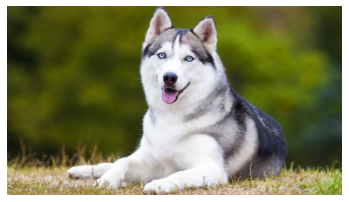

In [4]:
# 以OpenCV檢視輸入影像
import cv2
import matplotlib.pyplot as plt
import numpy as np
import requests

# 從網路獲取一張影像
file = requests.get("https://images.chinatimes.com/newsphoto/2021-04-05/1024/20210405002742.jpg")
# 將影像轉成OpenCV格式存入img中
img = cv2.imdecode(np.frombuffer(file.content, np.uint8), 1)
# 將img寫入磁碟命名為input.jpg
cv2.imwrite('input.jpg',img)

# 亦可直接讀取本地端影像
# img = cv2.imread('input.jpg')

rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # 將影像從BGR格式轉到RGB格式，才能讓plt.imshow()正確顯示
plt.figure() # 準備一顯示影像空間
plt.axis("off") # 設定關閉XY軸刻尺
plt.imshow(rgb) # 顯示影像

5.進行推論

在OpenVINO中大部份的範例程式都放在/opt/intel/openvino_2021/deployment_tools/inference_engine/demos中，但影像辨識是最基本的範例，所以不在其中，而是放在/opt/intel/openvino_2021/inference_engine/samples/python/下。
這裡使用/python/hello_classification/hello_classification.py來進行影像分類測試。這個範例適用上述數十種模型。
另外要依據不同的模型所對應的資料集給予標籤檔案，預設放在/opt/intel/openvino_2021/deployment_tools/open_model_zoo/data/dataset_classes下。

輸入參數：
-i 輸入影像名稱 (.png, .jpg ...)
-m 模型名稱 (.xml)
-nt 輸出置信度排序最高的前幾項（選配參數，預設為Top 10）
--labels 標籤名稱檔(.txt) （選配參數，不使用時會以id編號輸出，這裡要搭配無id之標籤檔案）

最後顯示推論結果，包括分類編號(classid)及置信度(probability) 

In [5]:
# 列出可支援標籤檔案(此步驟可忽略)
!ls /opt/intel/openvino_2021.3.394/deployment_tools/open_model_zoo/data/dataset_classes

aclnet_53cl.txt      coco_91cl.txt	   msasl100.json
cityscapes_19cl.txt  imagenet_2012.txt	   scut_ept.txt
coco_80cl_bkgr.txt   imagenet_2015.txt	   voc_20cl_bkgr.txt
coco_80cl.txt	     jester27.json	   voc_20cl.txt
coco_91cl_bkgr.txt   kondate_nakayosi.txt


In [6]:
# 複製無文字id的ImageNet 1000分類標籤檔到使用者目錄
!cp /opt/intel/openvino_2021/deployment_tools/demo/squeezenet1.1.labels imagenet_label.txt
!ls

# 設定環境變數執行影像分類推論
!source /opt/intel/openvino_2021/bin/setupvars.sh && \
python3 \
/opt/intel/openvino_2021/inference_engine/samples/python/hello_classification/hello_classification.py \
-i 'input.jpg' \
-m public/resnet-34-pytorch/FP32/resnet-34-pytorch.xml \
--labels "imagenet_label.txt"

darknet					      intel
DevCloud_OpenVINO_Face_Detection.ipynb	      output.jpg
DevCloud_OpenVINO_Image_Classification.ipynb  public
DevCloud_OpenVINO_Pose_Estimation.ipynb       test_0511.ipynb
devcloud-yolov4-tiny-test.ipynb		      Untitled.ipynb
DevCloud_Yolov4-tiny_Training.ipynb	      Webcam_Test_01.ipynb
face.jpg				      Yolov4-tiny_Colab_User_Datasets
imagenet_label.txt			      yolov4-tiny.conv.29
input.jpg				      yolov4-tiny.weights
[setupvars.sh] OpenVINO environment initialized
[ INFO ] Creating Inference Engine
[ INFO ] Loading network:
	public/resnet-34-pytorch/FP32/resnet-34-pytorch.xml
[ INFO ] Preparing input blobs
[ WARNING ] Image input.jpg is resized from (576, 1024) to (224, 224)
[ INFO ] Loading model to the plugin
[ INFO ] Starting inference in synchronous mode
[ INFO ] Processing output blob
[ INFO ] Top 10 results: 
Image input.jpg

classid probability
------- -----------
dog, husky 20.7688713
 husky   19.8722534
malemute, Alaskan malamute17.8152351
elkhound, 